In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
import fullmodel_v1_7
from Extract_data import extractData
from datetime import datetime, timedelta
from matplotlib.ticker import ScalarFormatter
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator

In [4]:
# Initial conditions
M_0 = 0
A_0 = 0.5
B_0 = 0.004  # 0.004
Q_B_0 = 0.01
Q_A_0 = 0.01
P_0 = 0.7  # 10
D_0 = 0.0239  # 0.0239
Y_0 = 0.025
W_0 = 0.02
O_0 = 7
v_A_0 = 0
v_D_0 = 0
v_Y_0 = 0
v_W_0 = 0


model_CyB = fullmodel_v1_7.modelCyB()

initial_conditions = [M_0, B_0, A_0,
                      Q_B_0,
                      Q_A_0, P_0,
                      D_0,
                      Y_0, W_0,
                      v_A_0, v_D_0,
                      v_Y_0, v_W_0, O_0]

# Data
year = "2021"
data = pd.read_excel("all-bloom-indicators.xlsx")

lake_name = "Pigeon Lake"

data = data[data["Waterbody name"] == lake_name]

data_fit = extractData(data, year)


t_data = data_fit["days"].values

# # import parameters


def read_params():
    model_CyB = fullmodel_v1_7.modelCyB()
    model_CyB.initial = initial_conditions
    name_data_param = "fitting_parameters_full_variables_v1"
    coment = "_v1_7_"
    name_data = './New data/'+lake_name + '/' \
        + name_data_param + year + lake_name+coment \
        + "_final" + ".csv"

    params_fit = pd.read_csv(name_data)

    # params_fit = pd.read_csv(
    #     "fitting_parameters_full_variables_v12021Pine Lake_v2__final.csv")
    unknow_params = ["e_BD", "alpha_B", "alpha_D",
                     "alpha_Y",
                     "tau_B", "tau_D", "tau_Y",
                     "a_A", "a_D", "sigma_A",
                     "sigma_D", "x_A", "x_D"]

    model_CyB.initial[1] = params_fit["B_0"][0]
    model_CyB.initial[2] = params_fit["A_0"][0]
    model_CyB.initial[6] = params_fit["D_0"][0]

    for name in unknow_params:
        model_CyB.params[name] = params_fit[name][0]

    # Death Daphnia
    model_CyB.params['n_D'] = 0.0623
    model_CyB.params['e_BD'] = 0.8
    model_CyB.params["tau_B"] = 1.23
    model_CyB.params["alpha_B"] = 0.0035
    # model_CyB.params["tau_Y"] = 1.23
    # # model_CyB.params["tau_D"] = 0.01
    # model_CyB.params["alpha_D"] = 0.003941
    # model_CyB.params['phi_D'] = 700
    # model_CyB.params['phi_Y'] = 700

    model_CyB.params['r_Y'] = 2
    model_CyB.params['r_W'] = 1
    model_CyB.params['Ext_Y'] = 0.025*13
    model_CyB.params['Ext_W'] = 0.025
    # model_CyB.params['p_in'] = 0.15*2

    # With Toxine
    model_CyB.toxines = True and (model_CyB.initial[1] > 0)
    # New time scale
    # days_before = 15

    # days_after = 60

    model_CyB.t_0 = 0

    # model_CyB.t_f = t_data.max()-t_data.min() + days_after

    model_CyB.t_f = 365

    model_CyB.delta_t = model_CyB.t_f*3

    model_CyB.set_linetime()

    t_data = data_fit["days"].values

    # Temperature

    model_CyB.max_temp_time = 197.3989-20
    # model_CyB.max_temp = 25.9
    # model_CyB.freq_temp = -0.0172
    # model_CyB.init_temp = t_data.min()

    # New time
    # t_data = t_data-t_data.min() + days_before
    return model_CyB

C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["Total cyanobacterial cell count (cells/mL)Tra"] = transformCyB(
C:\Users\brian\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["days"] = data_mean_year.index.dayofyear


In [5]:
model_CyB_base = read_params()

In [7]:
# Save the DataFrame to a CSV file
y1 = pd.read_csv('Sobol_index.csv', header=None)
y1 = y1.to_numpy()
# analyse
problem = {
    'num_vars': 6,
    'names': ['z_m',
              'd_E',
              'z_mK_bg',
              'p_in',
              'P_0',
              'Temp'],
    'bounds': [[1, 10],
               [0.02, 0.08],
               [0.3, 1.0],
               [0.1, 0.7],
               [0, 0.3],
               [0, 3.4]

               ]
}

sobol_indices = [sobol.analyze(problem, Y) for Y in y1.T]

C:\Users\brian\anaconda3\envs\python\lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


In [27]:
len(sobol_indices)

1095

In [10]:
def generate_dates(year):
    dates = []
    for month in range(1, 13):  # January to December
        next_month = month + 1 if month < 12 else 1  # Handle December
        # Handle December crossing into the next year
        next_year = year + 1 if month == 12 else year

        max_day = (datetime(next_year, next_month, 1) - timedelta(days=1)).day
        for day in range(1, max_day + 1, 1):
            start_date = datetime(year, month, day)
            # Adding one day to get the end date
            dates.append(start_date.strftime("%Y-%m-%d"))
    return dates

# Three Plots 

In [213]:
FigsizeAll = (11 / 2.54, 11 / 2.54)
# FigsizeSome = (7.5 / 2.54, 10.5 / 2.54)
FigsizeSome =(7.5 / 2.54, 10.5 / 2.54)
FORMAT = '.pdf'
FONTSIZE = 7
RESOLUTION = 800
NoBins = 25
SpaceDates = 5  # Space between dates to be plotted base on NoBins
Start_day = 0 #120  # Check dates
End_day = 365 #340
TIMEStap = (Start_day*3, End_day*3+1)  # Time to plot
dates = generate_dates(2021)
DATES = [date[5:] for date in dates][Start_day:End_day+1]
tick_len = 4  # Length for ticks with labels
other_tick_len = 2  # Length for other ticks
hspace = 0.35
wspace = 0.6
FONTSIZETITLE = 8
linewidth = 1
LegendWidth = 2
box_position = (1.225, 0.991) #right, hight
SAVE_PLOT = True
colors = cm.YlGnBu(np.linspace(0.25, 1, problem['num_vars']))

C:\Users\brian\AppData\Local\Temp\ipykernel_14568\1753836556.py:273: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lineleg in legend.legendHandles:


Image was saved


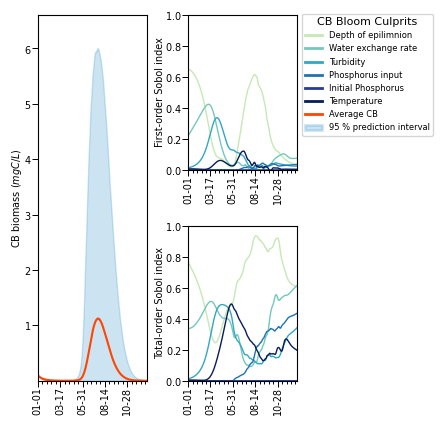

In [214]:
# Set the y-axis formatter to use scientific notation
y_formatter = ScalarFormatter(useMathText=True, useOffset=False)
y_formatter.set_powerlimits((-3, 4))  # Adjust the power limits as needed
y_formatter.orderOfMagnitude = 4  # Set the exponent to 4
# fig, axs = plt.subplots(1, 3, figsize=FigsizeSome)
# axs = axs.ravel()



fig = plt.figure(figsize=FigsizeSome, constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

S1s = np.array([s['S1'] for s in sobol_indices])
STs = np.array([s['ST'] for s in sobol_indices])

names = ['Depth of epilimnion',
        'Water exchange rate',
        'Turbidity',
        'Phosphorus input',
        'Initial Phosphorus',
        'Temperature']


max_values = 0
min_values = 0
for i in range(problem['num_vars']):
    
        # var = solution.T[variables.index(variables[i])]

        ax1.yaxis.set_major_formatter(y_formatter)

        ax1.tick_params(axis='y', labelsize=FONTSIZE,
                               pad=0.5)
        ax1.tick_params(axis='x', labelsize=FONTSIZE,
                               pad=0.5)

        for spine in ax1.spines.values():
            spine.set_color('black')  # Set all spines color to black

        ax1.tick_params(axis='both', which='both', bottom=True, top=False,
                               left=True, right=False, direction='out',
                               length=tick_len, width=0.7, colors='black')

        ax1.set_ylabel( 'First-order Sobol index', fontsize=FONTSIZE,
                              labelpad=0)

        max_values = max(
                max_values, S1s[:,i][TIMEStap[0]:TIMEStap[1]].max())
        min_values = min(
                min_values, S1s[:,i][TIMEStap[0]:TIMEStap[1]].min())

        ax1.set_ylim(min_values*(1-0.05)*0, max_values * (1+0.1)*0+1)
        ax1.set_xlim(model_CyB.t[TIMEStap[0]:TIMEStap[1]].min(),
                            model_CyB.t[TIMEStap[0]:TIMEStap[1]].max())

        ax1.xaxis.set_major_locator(
                MaxNLocator(integer=True, nbins=NoBins))

        x_ticks = ax1.xaxis.get_ticklocs()
        x_ticks = [tick for tick in x_ticks if tick <= 365]
        if len(dates) >= len(x_ticks):
            # max_tick = x_ticks.max()
            # No_days = len(DATES)
            

            x_labels = [''] * len(x_ticks)

                
            x_labels[::SpaceDates] = [dates[int(x_val)][5:]
                                          for x_val in x_ticks[:: SpaceDates] if x_val <= 365]
            ax1.set_xticks(x_ticks)

            ax1.xaxis.set_ticklabels(x_labels,
                                            rotation=90,
                                            fontsize=FONTSIZE)

            # Adjust the length of ticks with labels
            for tick in ax1.xaxis.get_major_ticks():
                if tick.label1.get_text():  # Check if tick has a label
                    tick.tick1line.set_markersize(tick_len)
                        
                else:
                    tick.tick1line.set_markersize(other_tick_len)
                        
        else:
            x_labels = dates
            ax1.xaxis.set_ticklabels(x_labels,
                                            rotation=30)
        ax1.set_xlabel('')
        ax1.grid(False)
        color_index = i

        line, = ax1.plot(model_CyB.t, S1s[:,i], color=colors[color_index],
                                    label=names[i],
                                    linewidth=linewidth)


max_values = 0
min_values = 0
for i in range(problem['num_vars']):
    
        # var = solution.T[variables.index(variables[i])]

        ax2.yaxis.set_major_formatter(y_formatter)

        ax2.tick_params(axis='y', labelsize=FONTSIZE,
                               pad=0.5)
        ax2.tick_params(axis='x', labelsize=FONTSIZE,
                               pad=0.5)

        for spine in ax2.spines.values():
            spine.set_color('black')  # Set all spines color to black

        ax2.tick_params(axis='both', which='both', bottom=True, top=False,
                               left=True, right=False, direction='out',
                               length=tick_len, width=0.7, colors='black')

        ax2.set_ylabel( 'Total-order Sobol index', fontsize=FONTSIZE,
                              labelpad=0)

        max_values = max(
                max_values, STs[:,i][TIMEStap[0]:TIMEStap[1]].max())
        min_values = min(
                min_values, STs[:,i][TIMEStap[0]:TIMEStap[1]].min())

        ax2.set_ylim(min_values*(1-0.05)*0, max_values * (1+0.1)*0+1)
        ax2.set_xlim(model_CyB.t[TIMEStap[0]:TIMEStap[1]].min(),
                            model_CyB.t[TIMEStap[0]:TIMEStap[1]].max())

        ax2.xaxis.set_major_locator(
                MaxNLocator(integer=True, nbins=NoBins))

        x_ticks = ax2.xaxis.get_ticklocs()
        x_ticks = [tick for tick in x_ticks if tick <= 365]
        if len(dates) >= len(x_ticks):
            # max_tick = x_ticks.max()
            # No_days = len(DATES)
            

            x_labels = [''] * len(x_ticks)

                
            x_labels[::SpaceDates] = [dates[int(x_val)][5:]
                                          for x_val in x_ticks[:: SpaceDates] if x_val <= 365]
            ax2.set_xticks(x_ticks)

            ax2.xaxis.set_ticklabels(x_labels,
                                            rotation=90,
                                            fontsize=FONTSIZE)

            # Adjust the length of ticks with labels
            for tick in ax2.xaxis.get_major_ticks():
                if tick.label1.get_text():  # Check if tick has a label
                    tick.tick1line.set_markersize(tick_len)
                        
                else:
                    tick.tick1line.set_markersize(other_tick_len)
                        
        else:
            x_labels = dates
            ax1.xaxis.set_ticklabels(x_labels,
                                            rotation=30)
        ax2.set_xlabel('')
        ax2.grid(False)
        color_index = i

        line, = ax2.plot(model_CyB.t, STs[:,i], color=colors[color_index],
                                    label=problem['names'][i],
                                    linewidth=linewidth)


 

# MEAN Value plot
# in percent
prediction_interval = 95

ax0.yaxis.set_major_formatter(y_formatter)

ax0.tick_params(axis='y', labelsize=FONTSIZE,
                               pad=0.5)
ax0.tick_params(axis='x', labelsize=FONTSIZE,
                               pad=0.5)

for spine in ax0.spines.values():
    spine.set_color('black')  # Set all spines color to black

ax0.tick_params(axis='both', which='both', bottom=True, top=False,
                               left=True, right=False, direction='out',
                               length=tick_len, width=0.7, colors='black')

ax0.set_ylabel("CB biomass ($mg C/L$)", fontsize=FONTSIZE,
                              labelpad=0)

    

ax0.set_ylim( np.mean(y1, axis=0).min()*(1-0.05), 
             np.percentile(y1, 50 + prediction_interval/2, axis=0).max() * (1+0.1))
ax0.set_xlim(model_CyB.t[TIMEStap[0]:TIMEStap[1]].min(),
                            model_CyB.t[TIMEStap[0]:TIMEStap[1]].max())

ax0.xaxis.set_major_locator(
                MaxNLocator(integer=True, nbins=NoBins))

x_ticks = ax0.xaxis.get_ticklocs()
x_ticks = [tick for tick in x_ticks if tick <= 365]
if len(dates) >= len(x_ticks):
    x_labels = [''] * len(x_ticks)

                
    x_labels[::SpaceDates] = [dates[int(x_val)][5:]
                                          for x_val in x_ticks[:: SpaceDates] if x_val <= 365]
    ax0.set_xticks(x_ticks)

    ax0.xaxis.set_ticklabels(x_labels,
                                rotation=90,
                                fontsize=FONTSIZE)

    # Adjust the length of ticks with labels
    for tick in ax0.xaxis.get_major_ticks():
        if tick.label1.get_text():  # Check if tick has a label
            tick.tick1line.set_markersize(tick_len)
                        
        else:
            tick.tick1line.set_markersize(other_tick_len)
                        
else:
        x_labels = dates
        ax0.xaxis.set_ticklabels(x_labels,
                                            rotation=30)
ax0.set_xlabel('')
ax0.grid(False)



ax0.plot(model_CyB.t, np.mean(y1, axis=0), label="Average CB", color='#FF4500')



ax0.fill_between(model_CyB_base.t,
                 np.percentile(y1, 50 - prediction_interval/2., axis=0),
                 np.percentile(y1, 50 + prediction_interval/2., axis=0),
                 alpha=0.25, color= np.array((53, 148, 204))/255,
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("")
# ax0.legend(title=r"",
#            loc='upper left')._legend_box.align = "left"    
    
    
    
    # # Adjust the spacing between subplots
# plt.subplots_adjust(hspace=hspace, wspace=wspace)


handles, labels = ax1.get_legend_handles_labels()

handles0, labels0 = ax0.get_legend_handles_labels()

handles = handles + handles0
labels = labels + labels0

legend = fig.legend(handles, labels, loc='outside upper center',
                            bbox_to_anchor=box_position,
                            fancybox=True, shadow=False, ncol=1,
                            title='CB Bloom Culprits',
                            fontsize=FONTSIZE-1,
                            title_fontsize=FONTSIZETITLE)
for lineleg in legend.legendHandles:
        lineleg.set_linewidth(LegendWidth)


if SAVE_PLOT:
    # Save plots
    path = './New data/Images/Year v_1/'
    name = 'CB_Sobol_index'+FORMAT
    plt.savefig(path+name, dpi=RESOLUTION, bbox_inches='tight')
    print('Image was saved')
    # Show the plot
plt.show()

# Two Plots

In [252]:
FigsizeAll = (11 / 2.54, 11 / 2.54)
# FigsizeSome = (7.5 / 2.54, 10.5 / 2.54)
FigsizeSome =(7.5 / 2.54, 5.5 / 2.54)
FORMAT = '.pdf'
FONTSIZE = 7
RESOLUTION = 900
NoBins = 25
SpaceDates = 5  # Space between dates to be plotted base on NoBins
Start_day = 0 #120  # Check dates
End_day = 365 #340
TIMEStap = (Start_day*3, End_day*3+1)  # Time to plot
dates = generate_dates(2021)
DATES = [date[5:] for date in dates][Start_day:End_day+1]
tick_len = 4  # Length for ticks with labels
other_tick_len = 2  # Length for other ticks
hspace = 0.35
wspace = 0.6
FONTSIZETITLE = 8
linewidth = 1
LegendWidth = 2
box_position = (0.55, 0.991) #right, hight
SAVE_PLOT = True
# colors = cm.Set1_r(np.linspace(0.25, 1, problem['num_vars']))
colors = np.array([np.array([110,158,206])/255,
          np.array([78,149,149])/255,
          np.array([141,106,184])/255,
          np.array([132,87,77])/255,
          np.array([233,169,107])/255,
          np.array([230,146,143])/255])

C:\Users\brian\AppData\Local\Temp\ipykernel_14568\2123432844.py:189: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lineleg in legend.legendHandles:


Image was saved


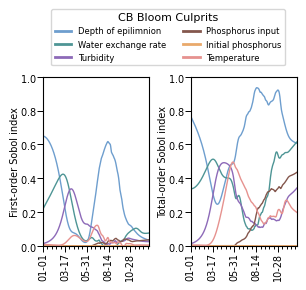

In [253]:
# Set the y-axis formatter to use scientific notation
y_formatter = ScalarFormatter(useMathText=True, useOffset=False)
y_formatter.set_powerlimits((-3, 4))  # Adjust the power limits as needed
y_formatter.orderOfMagnitude = 4  # Set the exponent to 4
# fig, axs = plt.subplots(1, 3, figsize=FigsizeSome)
# axs = axs.ravel()



fig = plt.figure(figsize=FigsizeSome, constrained_layout=True)
gs = fig.add_gridspec(1, 2)

# ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

S1s = np.array([s['S1'] for s in sobol_indices])
STs = np.array([s['ST'] for s in sobol_indices])

names = ['Depth of epilimnion',
        'Water exchange rate',
        'Turbidity',
        'Phosphorus input',
        'Initial phosphorus',
        'Temperature']


max_values = 0
min_values = 0
for i in range(problem['num_vars']):
    
        # var = solution.T[variables.index(variables[i])]

        ax1.yaxis.set_major_formatter(y_formatter)

        ax1.tick_params(axis='y', labelsize=FONTSIZE,
                               pad=0.5)
        ax1.tick_params(axis='x', labelsize=FONTSIZE,
                               pad=0.5)

        for spine in ax1.spines.values():
            spine.set_color('black')  # Set all spines color to black

        ax1.tick_params(axis='both', which='both', bottom=True, top=False,
                               left=True, right=False, direction='out',
                               length=tick_len, width=0.7, colors='black')

        ax1.set_ylabel( 'First-order Sobol index', fontsize=FONTSIZE,
                              labelpad=0)

        max_values = max(
                max_values, S1s[:,i][TIMEStap[0]:TIMEStap[1]].max())
        min_values = min(
                min_values, S1s[:,i][TIMEStap[0]:TIMEStap[1]].min())

        ax1.set_ylim(min_values*(1-0.05)*0, max_values * (1+0.1)*0+1)
        ax1.set_xlim(model_CyB.t[TIMEStap[0]:TIMEStap[1]].min(),
                            model_CyB.t[TIMEStap[0]:TIMEStap[1]].max())

        ax1.xaxis.set_major_locator(
                MaxNLocator(integer=True, nbins=NoBins))

        x_ticks = ax1.xaxis.get_ticklocs()
        x_ticks = [tick for tick in x_ticks if tick <= 365]
        if len(dates) >= len(x_ticks):
            # max_tick = x_ticks.max()
            # No_days = len(DATES)
            

            x_labels = [''] * len(x_ticks)

                
            x_labels[::SpaceDates] = [dates[int(x_val)][5:]
                                          for x_val in x_ticks[:: SpaceDates] if x_val <= 365]
            ax1.set_xticks(x_ticks)

            ax1.xaxis.set_ticklabels(x_labels,
                                            rotation=90,
                                            fontsize=FONTSIZE)

            # Adjust the length of ticks with labels
            for tick in ax1.xaxis.get_major_ticks():
                if tick.label1.get_text():  # Check if tick has a label
                    tick.tick1line.set_markersize(tick_len)
                        
                else:
                    tick.tick1line.set_markersize(other_tick_len)
                        
        else:
            x_labels = dates
            ax1.xaxis.set_ticklabels(x_labels,
                                            rotation=30)
        ax1.set_xlabel('')
        ax1.grid(False)
        color_index = i

        line, = ax1.plot(model_CyB.t, S1s[:,i], color=colors[color_index],
                                    label=names[i],
                                    linewidth=linewidth)


max_values = 0
min_values = 0
for i in range(problem['num_vars']):
    
        # var = solution.T[variables.index(variables[i])]

        ax2.yaxis.set_major_formatter(y_formatter)

        ax2.tick_params(axis='y', labelsize=FONTSIZE,
                               pad=0.5)
        ax2.tick_params(axis='x', labelsize=FONTSIZE,
                               pad=0.5)

        for spine in ax2.spines.values():
            spine.set_color('black')  # Set all spines color to black

        ax2.tick_params(axis='both', which='both', bottom=True, top=False,
                               left=True, right=False, direction='out',
                               length=tick_len, width=0.7, colors='black')

        ax2.set_ylabel( 'Total-order Sobol index', fontsize=FONTSIZE,
                              labelpad=0)

        max_values = max(
                max_values, STs[:,i][TIMEStap[0]:TIMEStap[1]].max())
        min_values = min(
                min_values, STs[:,i][TIMEStap[0]:TIMEStap[1]].min())

        ax2.set_ylim(min_values*(1-0.05)*0, max_values * (1+0.1)*0+1)
        ax2.set_xlim(model_CyB.t[TIMEStap[0]:TIMEStap[1]].min(),
                            model_CyB.t[TIMEStap[0]:TIMEStap[1]].max())

        ax2.xaxis.set_major_locator(
                MaxNLocator(integer=True, nbins=NoBins))

        x_ticks = ax2.xaxis.get_ticklocs()
        x_ticks = [tick for tick in x_ticks if tick <= 365]
        if len(dates) >= len(x_ticks):
            # max_tick = x_ticks.max()
            # No_days = len(DATES)
            

            x_labels = [''] * len(x_ticks)

                
            x_labels[::SpaceDates] = [dates[int(x_val)][5:]
                                          for x_val in x_ticks[:: SpaceDates] if x_val <= 365]
            ax2.set_xticks(x_ticks)

            ax2.xaxis.set_ticklabels(x_labels,
                                            rotation=90,
                                            fontsize=FONTSIZE)

            # Adjust the length of ticks with labels
            for tick in ax2.xaxis.get_major_ticks():
                if tick.label1.get_text():  # Check if tick has a label
                    tick.tick1line.set_markersize(tick_len)
                        
                else:
                    tick.tick1line.set_markersize(other_tick_len)
                        
        else:
            x_labels = dates
            ax1.xaxis.set_ticklabels(x_labels,
                                            rotation=30)
        ax2.set_xlabel('')
        ax2.grid(False)
        color_index = i

        line, = ax2.plot(model_CyB.t, STs[:,i], color=colors[color_index],
                                    label=problem['names'][i],
                                    linewidth=linewidth)


 

# MEAN Value plot
# in percent

handles, labels = ax1.get_legend_handles_labels()

legend = fig.legend(handles, labels, loc='outside lower center',
                            bbox_to_anchor=box_position,
                            fancybox=True, shadow=False, ncol=2,
                            title='CB Bloom Culprits',
                            fontsize=FONTSIZE-1,
                            title_fontsize=FONTSIZETITLE)
for lineleg in legend.legendHandles:
        lineleg.set_linewidth(LegendWidth)


if SAVE_PLOT:
    # Save plots
    path = './New data/Images/Year v_1/'
    name = 'CB_Sobol_index'+FORMAT
    plt.savefig(path+name, dpi=RESOLUTION, bbox_inches='tight')
    print('Image was saved')
    # Show the plot
plt.show()

# Vertion 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
import fullmodel_v1_7
from Extract_data import extractData
from datetime import datetime, timedelta
from matplotlib.ticker import ScalarFormatter
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator

In [2]:
# Initial conditions
M_0 = 0
A_0 = 0.5
B_0 = 0.004  # 0.004
Q_B_0 = 0.01
Q_A_0 = 0.01
P_0 = 0.7  # 10
D_0 = 0.0239  # 0.0239
Y_0 = 0.025
W_0 = 0.02
O_0 = 7
v_A_0 = 0
v_D_0 = 0
v_Y_0 = 0
v_W_0 = 0


model_CyB = fullmodel_v1_7.modelCyB()

initial_conditions = [M_0, B_0, A_0,
                      Q_B_0,
                      Q_A_0, P_0,
                      D_0,
                      Y_0, W_0,
                      v_A_0, v_D_0,
                      v_Y_0, v_W_0, O_0]

# Data
year = "2021"
data = pd.read_excel("all-bloom-indicators.xlsx")

lake_name = "Pigeon Lake"

data = data[data["Waterbody name"] == lake_name]

data_fit = extractData(data, year)


t_data = data_fit["days"].values

# # import parameters


def read_params():
    model_CyB = fullmodel_v1_7.modelCyB()
    model_CyB.initial = initial_conditions
    name_data_param = "fitting_parameters_full_variables_v1"
    coment = "_v1_7_"
    name_data = './New data/'+lake_name + '/' \
        + name_data_param + year + lake_name+coment \
        + "_final" + ".csv"

    params_fit = pd.read_csv(name_data)

    # params_fit = pd.read_csv(
    #     "fitting_parameters_full_variables_v12021Pine Lake_v2__final.csv")
    unknow_params = ["e_BD", "alpha_B", "alpha_D",
                     "alpha_Y",
                     "tau_B", "tau_D", "tau_Y",
                     "a_A", "a_D", "sigma_A",
                     "sigma_D", "x_A", "x_D"]

    model_CyB.initial[1] = params_fit["B_0"][0]
    model_CyB.initial[2] = params_fit["A_0"][0]
    model_CyB.initial[6] = params_fit["D_0"][0]

    for name in unknow_params:
        model_CyB.params[name] = params_fit[name][0]

    # Death Daphnia
    model_CyB.params['n_D'] = 0.0623
    model_CyB.params['e_BD'] = 0.8
    model_CyB.params["tau_B"] = 1.23
    model_CyB.params["alpha_B"] = 0.0035
    # model_CyB.params["tau_Y"] = 1.23
    # # model_CyB.params["tau_D"] = 0.01
    # model_CyB.params["alpha_D"] = 0.003941
    # model_CyB.params['phi_D'] = 700
    # model_CyB.params['phi_Y'] = 700

    model_CyB.params['r_Y'] = 2
    model_CyB.params['r_W'] = 1
    model_CyB.params['Ext_Y'] = 0.025*13
    model_CyB.params['Ext_W'] = 0.025
    # model_CyB.params['p_in'] = 0.15*2

    # With Toxine
    model_CyB.toxines = True and (model_CyB.initial[1] > 0)
    # New time scale
    # days_before = 15

    # days_after = 60

    model_CyB.t_0 = 0

    # model_CyB.t_f = t_data.max()-t_data.min() + days_after

    model_CyB.t_f = 365

    model_CyB.delta_t = model_CyB.t_f*3

    model_CyB.set_linetime()

    t_data = data_fit["days"].values

    # Temperature

    model_CyB.max_temp_time = 197.3989-20
    # model_CyB.max_temp = 25.9
    # model_CyB.freq_temp = -0.0172
    # model_CyB.init_temp = t_data.min()

    # New time
    # t_data = t_data-t_data.min() + days_before
    return model_CyB

D:\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["Total cyanobacterial cell count (cells/mL)Tra"] = transformCyB(
D:\Documents\University of Alberta\ACA-Cyanobacteria bloom modelling and prediction\Simulations\New folder\Extract_data.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mean_year["days"] = data_mean_year.index.dayofyear


In [3]:
model_CyB_base = read_params()

In [4]:
# Save the DataFrame to a CSV file
y1 = pd.read_csv('Sobol_indexV2.csv', header=None)
y1 = y1.to_numpy()
# analyse
problem = {
    'num_vars': 6,
    'names': ['z_m',
              'd_E',
              'z_mK_bg',
              'p_in',
              'P_0',
              'Temp'],
    'bounds': [[1, 10],
               [0.02, 0.08],
               [0.3, 1.0],
               [0.1, 0.7],
               [0, 0.3],
               [0, 3.4]

               ]
}

sobol_indices = [sobol.analyze(problem, Y) for Y in y1.T]

C:\Users\brian\anaconda3\envs\python\lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


In [5]:
len(sobol_indices) , y1.shape

(1095, (14336, 1095))

In [6]:
def generate_dates(year):
    dates = []
    for month in range(1, 13):  # January to December
        next_month = month + 1 if month < 12 else 1  # Handle December
        # Handle December crossing into the next year
        next_year = year + 1 if month == 12 else year

        max_day = (datetime(next_year, next_month, 1) - timedelta(days=1)).day
        for day in range(1, max_day + 1, 1):
            start_date = datetime(year, month, day)
            # Adding one day to get the end date
            dates.append(start_date.strftime("%Y-%m-%d"))
    return dates

In [7]:
FigsizeAll = (11 / 2.54, 11 / 2.54)
# FigsizeSome = (7.5 / 2.54, 10.5 / 2.54)
FigsizeSome =(7.5 / 2.54, 5.5 / 2.54)
FORMAT = '.pdf'
FONTSIZE = 7
RESOLUTION = 900
NoBins = 25
SpaceDates = 5  # Space between dates to be plotted base on NoBins
Start_day = 0 #120  # Check dates
End_day = 365 #340
TIMEStap = (Start_day*3, End_day*3+1)  # Time to plot
dates = generate_dates(2021)
DATES = [date[5:] for date in dates][Start_day:End_day+1]
tick_len = 4  # Length for ticks with labels
other_tick_len = 2  # Length for other ticks
hspace = 0.35
wspace = 0.6
FONTSIZETITLE = 8
linewidth = 1
LegendWidth = 2
box_position = (0.55, 0.991) #right, hight
SAVE_PLOT = True
# colors = cm.Set1_r(np.linspace(0.25, 1, problem['num_vars'])) #[110,158,206]
colors = np.array([np.array([9, 99, 189])/255,
          np.array([78,149,149])/255,
          np.array([141,106,184])/255,
          np.array([132,87,77])/255,
          np.array([233,169,107])/255,
          np.array([230,146,143])/255])

colors = ["#2f4c6b",
"#984ea3",
"#5e5522",
"#dc9650",
"#995528",
"#bb3039"]

colors = ["#13313f",
"#66829a",
"#536642",
"#cabe45",
"#995528",
"#bb3039"]

colors = ["#13313f",
"#66829a",
"#85a369",
"#cedc65",
"#6a4c92",
"#bb3039"]

C:\Users\brian\AppData\Local\Temp\ipykernel_10756\2372557758.py:191: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lineleg in legend.legendHandles:


Image was saved


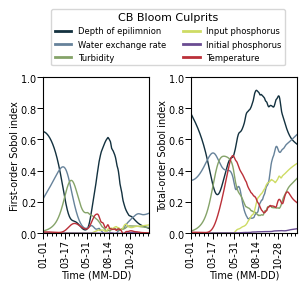

In [8]:
# Set the y-axis formatter to use scientific notation
y_formatter = ScalarFormatter(useMathText=True, useOffset=False)
y_formatter.set_powerlimits((-3, 4))  # Adjust the power limits as needed
y_formatter.orderOfMagnitude = 4  # Set the exponent to 4
# fig, axs = plt.subplots(1, 3, figsize=FigsizeSome)
# axs = axs.ravel()



fig = plt.figure(figsize=FigsizeSome, constrained_layout=True)
gs = fig.add_gridspec(1, 2)

# ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

S1s = np.array([s['S1'] for s in sobol_indices])
STs = np.array([s['ST'] for s in sobol_indices])

names = ['Depth of epilimnion',
        'Water exchange rate',
        'Turbidity',
        'Input phosphorus',
        'Initial phosphorus',
        'Temperature']


max_values = 0
min_values = 0
for i in range(problem['num_vars']):
    
        # var = solution.T[variables.index(variables[i])]

        ax1.yaxis.set_major_formatter(y_formatter)

        ax1.tick_params(axis='y', labelsize=FONTSIZE,
                               pad=0.5)
        ax1.tick_params(axis='x', labelsize=FONTSIZE,
                               pad=0.5)

        for spine in ax1.spines.values():
            spine.set_color('black')  # Set all spines color to black

        ax1.tick_params(axis='both', which='both', bottom=True, top=False,
                               left=True, right=False, direction='out',
                               length=tick_len, width=0.7, colors='black')

        ax1.set_ylabel( 'First-order Sobol index', fontsize=FONTSIZE,
                              labelpad=0)

        max_values = max(
                max_values, S1s[:,i][TIMEStap[0]:TIMEStap[1]].max())
        min_values = min(
                min_values, S1s[:,i][TIMEStap[0]:TIMEStap[1]].min())

        ax1.set_ylim(min_values*(1-0.05)*0, max_values * (1+0.1)*0+1)
        ax1.set_xlim(model_CyB.t[TIMEStap[0]:TIMEStap[1]].min(),
                            model_CyB.t[TIMEStap[0]:TIMEStap[1]].max())

        ax1.xaxis.set_major_locator(
                MaxNLocator(integer=True, nbins=NoBins))

        x_ticks = ax1.xaxis.get_ticklocs()
        x_ticks = [tick for tick in x_ticks if tick <= 365]
        if len(dates) >= len(x_ticks):
            # max_tick = x_ticks.max()
            # No_days = len(DATES)
            

            x_labels = [''] * len(x_ticks)

                
            x_labels[::SpaceDates] = [dates[int(x_val)][5:]
                                          for x_val in x_ticks[:: SpaceDates] if x_val <= 365]
            ax1.set_xticks(x_ticks)

            ax1.xaxis.set_ticklabels(x_labels,
                                            rotation=90,
                                            fontsize=FONTSIZE)

            # Adjust the length of ticks with labels
            for tick in ax1.xaxis.get_major_ticks():
                if tick.label1.get_text():  # Check if tick has a label
                    tick.tick1line.set_markersize(tick_len)
                        
                else:
                    tick.tick1line.set_markersize(other_tick_len)
                        
        else:
            x_labels = dates
            ax1.xaxis.set_ticklabels(x_labels,
                                            rotation=30)
        ax1.set_xlabel('Time (MM-DD)', fontsize=FONTSIZE,
                              labelpad=2)
        ax1.grid(False)
        color_index = i

        line, = ax1.plot(model_CyB.t, S1s[:,i], color=colors[color_index],
                                    label=names[i],
                                    linewidth=linewidth)


max_values = 0
min_values = 0
for i in range(problem['num_vars']):
    
        # var = solution.T[variables.index(variables[i])]

        ax2.yaxis.set_major_formatter(y_formatter)

        ax2.tick_params(axis='y', labelsize=FONTSIZE,
                               pad=0.5)
        ax2.tick_params(axis='x', labelsize=FONTSIZE,
                               pad=0.5)

        for spine in ax2.spines.values():
            spine.set_color('black')  # Set all spines color to black

        ax2.tick_params(axis='both', which='both', bottom=True, top=False,
                               left=True, right=False, direction='out',
                               length=tick_len, width=0.7, colors='black')

        ax2.set_ylabel( 'Total-order Sobol index', fontsize=FONTSIZE,
                              labelpad=0)

        max_values = max(
                max_values, STs[:,i][TIMEStap[0]:TIMEStap[1]].max())
        min_values = min(
                min_values, STs[:,i][TIMEStap[0]:TIMEStap[1]].min())

        ax2.set_ylim(min_values*(1-0.05)*0, max_values * (1+0.1)*0+1)
        ax2.set_xlim(model_CyB.t[TIMEStap[0]:TIMEStap[1]].min(),
                            model_CyB.t[TIMEStap[0]:TIMEStap[1]].max())

        ax2.xaxis.set_major_locator(
                MaxNLocator(integer=True, nbins=NoBins))

        x_ticks = ax2.xaxis.get_ticklocs()
        x_ticks = [tick for tick in x_ticks if tick <= 365]
        if len(dates) >= len(x_ticks):
            # max_tick = x_ticks.max()
            # No_days = len(DATES)
            

            x_labels = [''] * len(x_ticks)

                
            x_labels[::SpaceDates] = [dates[int(x_val)][5:]
                                          for x_val in x_ticks[:: SpaceDates] if x_val <= 365]
            ax2.set_xticks(x_ticks)

            ax2.xaxis.set_ticklabels(x_labels,
                                            rotation=90,
                                            fontsize=FONTSIZE)

            # Adjust the length of ticks with labels
            for tick in ax2.xaxis.get_major_ticks():
                if tick.label1.get_text():  # Check if tick has a label
                    tick.tick1line.set_markersize(tick_len)
                        
                else:
                    tick.tick1line.set_markersize(other_tick_len)
                        
        else:
            x_labels = dates
            ax1.xaxis.set_ticklabels(x_labels,
                                            rotation=30)
        ax2.set_xlabel('Time (MM-DD)', fontsize=FONTSIZE,
                              labelpad=2)
        ax2.grid(False)
        color_index = i

        line, = ax2.plot(model_CyB.t, STs[:,i], color=colors[color_index],
                                    label=problem['names'][i],
                                    linewidth=linewidth)


 

# MEAN Value plot
# in percent

handles, labels = ax1.get_legend_handles_labels()

legend = fig.legend(handles, labels, loc='outside lower center',
                            bbox_to_anchor=box_position,
                            fancybox=True, shadow=False, ncol=2,
                            title='CB Bloom Culprits',
                            fontsize=FONTSIZE-1,
                            title_fontsize=FONTSIZETITLE)
for lineleg in legend.legendHandles:
        lineleg.set_linewidth(LegendWidth)


if SAVE_PLOT:
    # Save plots
    path = './New data/Images/Year v_1/'
    name = 'CB_Sobol_index'+FORMAT
    plt.savefig(path+name, dpi=RESOLUTION, bbox_inches='tight')
    print('Image was saved')
    # Show the plot
plt.show()